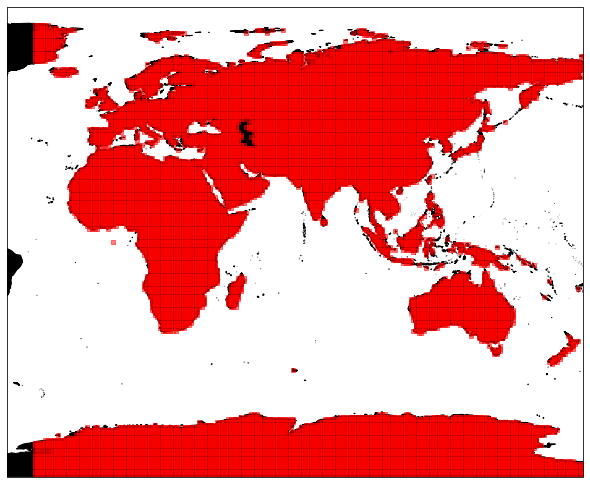

In [1]:
from IPython import embed
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from shapely.geometry import Point
import cartopy
from shapely.prepared import prep
import seaborn as sns
%matplotlib inline
import scipy.sparse as sp
from scipy.sparse.linalg.dsolve import spsolve
from scipy.sparse.linalg import bicgstab, bicg, cg, cgs, gmres, lgmres, minres, qmr, gcrotmk
import matplotlib.animation as animation
from IPython.display import HTML

land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m')
land_polygons = list(land_10m.geometries())

lats = np.arange(-100,100,1 )
lons = np.arange(-30,1000, 1)
lon_grid, lat_grid = np.meshgrid(lons, lats)

points = [Point(point) for point in zip(lon_grid.ravel(), lat_grid.ravel())]


land_polygons_prep = [prep(land_polygon) for land_polygon in land_polygons]


land = []
for land_polygon in land_polygons_prep:
    land.extend([tuple(point.coords)[0] for point in filter(land_polygon.covers, points)])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

ax.add_feature(land_10m, zorder=0, edgecolor='black', facecolor=sns.xkcd_rgb['black'])

xs, ys = zip(*land)
ax.scatter(xs, ys, transform=ccrs.PlateCarree(),
       s=12, marker='s', c='red', alpha=0.5, zorder=2)

In [2]:
Nx = lats.shape[0]
Ny =lons.shape[0]
C = np.zeros((211,173))

In [3]:
where_land = [ (int(x[0]+30),int(x[1]+89)) for x in land]

In [4]:
for x in where_land:
    C[x]=1

In [5]:
C

array([[1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [6]:
world_map = C[:,::-1].transpose()

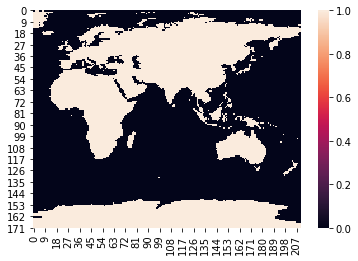

In [7]:
sns.heatmap(world_map)

In [8]:
C0 = np.zeros((211,211))

In [9]:
world_map.shape

(173, 211)

In [10]:
C0[:173,:211]=world_map

In [11]:
C0[45,45]

1.0

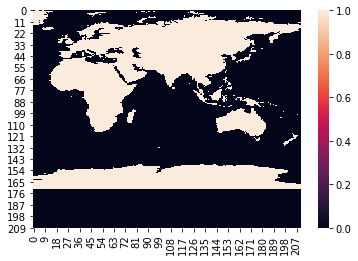

In [12]:
sns.heatmap(C0)

In [66]:
# %load ../edp_2d.py
c0 = C0.ravel()
n_x = C0.shape[0]


import time
start_time = time.time()

#Coéfficients physiques
K=.000005#coefficient diffusion
b= .9# dtC=-b*rho*C
F0= 1 # dtRho = Fo*Mu

physique = [K,b,F0]

#Paramêtres numériques 
n_t=2000 #nombre de pas de temps
tf=1000 # temps final de la simulation
xf = n_x #longueur de la simulation
yf = xf
n_y = n_x 
n_xy = n_x * n_y
numerique = [n_t,tf,xf,n_x,yf,n_y]

params = physique,numerique


#Données initiales 
rho0=np.zeros(n_xy) #rho initial	
mu0=np.zeros(n_xy)#mu initial
mu0[165*211]=.01

        
class EDP():
    def __init__(self,params):
        self.physique, self.numerique = params
        self.K,self.b,self.F0 = self.physique
        self.n_t,self.tf,self.xf,self.n_x,self.yf,self.n_y = self.numerique
        
        
        self.n_xy = self.n_x*self.n_y
        self.dt = self.tf/(self.n_t-1)
        self.dx = self.xf/(self.n_x-1)
        self.dy = self.yf/(self.n_y-1)
        
        #self.X = np.linspace(0,self.xf,self.n_x)
        #self.Y = np.linspace(0,self.yf,self.n_y)
        #self.T = np.linspace(0,self.tf,self.n_t)

        #Matrice du Laplacien
        self.Lapl = sp.diags(-4*np.ones(self.n_xy),0)
        #Lapl += sp.diags(np.ones(n_xy-1),1)+sp.diags(np.ones(n_xy-1),-1)
        diagmod = np.ones(self.n_xy-1)
        diagmod[np.arange(self.n_y-1,self.n_xy-1,self.n_y)] = np.zeros(self.n_y-1)
        self.Lapl += sp.diags(diagmod,1) + sp.diags(diagmod,-1)
        self.Lapl += sp.diags(np.ones(self.n_xy-self.n_y),self.n_y)+sp.diags(np.ones(self.n_xy-self.n_y),-self.n_y)
        self.Lapl = -self.K*self.dt/(self.dx**2)*self.Lapl
    def array_to_2D(n_x,vect):
        return np.array(np.split(vect,n_x))

    def integrate(self,initial):
        mu,rho,c = initial
        alpha=-c*self.dt*(1+self.dt*self.F0)+self.dt*rho+1
        A = self.Lapl + sp.diags(alpha,0)
        Target =  mu+self.dt*c*rho
        
        #next_mu = spsolve(A,Target) #95.28 secondes d'execution
        #next_mu,check = bicg(A,Target) #3.38 secondes d'execution
        #next_mu,check = bicgstab(A,Target, x0=mu) #2.15 secondes d'execution
        #next_mu,check = cg(A,Target) #2.29 secondes d'execution
        #next_mu,check = cgs(A,Target) #2.36 secondes d'execution
        #next_mu,check = gmres(A,Target) #2.72 secondes d'execution
        #next_mu,check = lgmres(A,Target) #2.62 secondes d'execution
        next_mu,check = minres(A,Target, x0=mu) #2.15 secondes d'execution
        #next_mu,check = qmr(A,Target) #3.70 secondes d'execution
        #next_mu,check = gcrotmk(A,Target) #2.62 secondes d'execution
        next_rho = rho + self.dt*self.F0*next_mu
        next_c = c/(1+self.b*self.dt*next_rho)
        return next_mu, next_rho, next_c
        
        
Agent = EDP(params)

mu= mu0
rho= rho0
c= c0
Mu=[mu0]
Rho=[rho0]
C=[c0]
n = 0
N_print = 100
n_print = 0
while n<n_t:
    mu,rho,c = Agent.integrate((mu,rho,c)) 
  #  mu[mu<1e-25]=0
    if n>n_print * n_t / N_print :
        n_print +=1
        Mu.append(mu)
        Rho.append(rho)
        C.append(c)
    if n % 25 ==0 :
        print(n, (time.time() - start_time))
    n+=1

print("--- %s seconds ---" % (time.time() - start_time))

tot = len(Mu)

0 0.06077432632446289
25 0.25205254554748535
50 0.6971349716186523
75 1.2173490524291992
100 1.7498445510864258
125 2.2752485275268555
150 2.8665976524353027
175 3.487673044204712
200 4.103392839431763
225 4.716881513595581
250 5.39227819442749
275 6.023036241531372
300 6.624873161315918
325 7.333855867385864
350 7.967835426330566
375 8.574440002441406
400 9.263333797454834
425 9.977996587753296
450 10.687876462936401
475 11.435202836990356
500 12.158503532409668
525 12.924593687057495
550 13.671949625015259
575 14.375714540481567
600 15.101364612579346
625 15.835711002349854
650 16.565649032592773
675 17.326570510864258
700 18.100290775299072
725 18.845463752746582
750 19.61992597579956
775 20.354130744934082
800 21.154879093170166
825 21.927098035812378
850 22.646556615829468
875 23.396228790283203
900 24.103187561035156
925 24.796629667282104
950 25.51458764076233
975 26.192981719970703
1000 26.862610816955566
1025 27.525739192962646
1050 28.17228102684021
1075 28.831870079040527
11

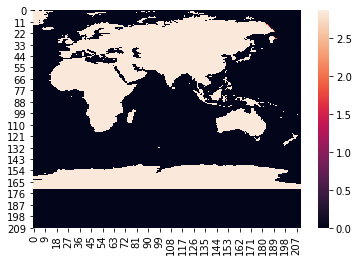

In [67]:
sns.heatmap(EDP.array_to_2D(n_x,Rho[90]))


In [68]:
data = []
for i in range(len(Rho)):
    data += [EDP.array_to_2D(n_x,Rho[i])]

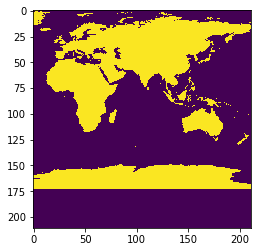

In [69]:

fig = plt.figure()
im = plt.imshow(data[100])
def init():
    im.set_array(data[100])
    return im,

def animate(i):
    im.set_array(data[i])
    return im,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=100, repeat = False)

In [70]:
HTML(anim.to_jshtml())

In [18]:
anim.save('im.mp4', writer='ffmpeg')